## Tracer concentration within the canyon

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_context('paper')
sns.set_style('white')

In [3]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho



def call_rho(t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


In [4]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [5]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [6]:
state_filekv3 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/stateGlob.nc' 
statekv3 = xr.open_dataset(state_filekv3)

ptracers_filekv3 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/ptracersGlob.nc'
ptracerskv3 = xr.open_dataset(ptracers_filekv3)


In [7]:
state_filekv2 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run06/stateGlob.nc' 
statekv2 = xr.open_dataset(state_filekv2)

ptracers_filekv2 = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run06/ptracersGlob.nc'
ptracerskv2 = xr.open_dataset(ptracers_filekv2)


In [8]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [9]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii = ii+1
select_rec = [0,2,12,15,5,9,18]

labels = ['Base case', r'highest $\kappa_{bg}$',r'high $\kappa_{can}$',r'highest $\kappa_{can}$',
          r'lower $N$',r'lowest $f$',r'lowest $U$']

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run67
7 CNTDIFF_run51
8 CNTDIFF_run69
9 CNTDIFF_run71
10 3DVISC_run01
11 3DVISC_run02
12 3DVISC_run03
13 3DVISC_run04
14 3DVISC_run05
15 3DVISC_run06
16 LOWER_BF_run01
17 LOW_BF_run01
18 LOWEST_BF_run01
19 LOWEST_BF_run03
20 LOWEST_BF_run05
21 LOWEST_BF_run07
22 LOWEST_BF_run11


In [10]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt06','dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    df_anom2 = (df.sub(df[key0].squeeze(),axis=0)) 
    
    maxd3 = min(df_anom[keys[0]][22:26])
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    
    
    record.maxdTr = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stddTr = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.dTrprof = -df_anom[keys[2]][:]
    record.dTrprof7 = -df_anom[keys[4]][:]
    record.dTrprof0 = -df_anom[key0][:]
     

In [11]:
keys = ['Tr_profile_tt06','Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
        
    record.Cprof = df[keys[2]][:]
    record.Cprof7 = df[keys[4]][:]
    



In [12]:

keys = ['N_tt06','N_tt08','N_tt10','N_tt12']
key0 = 'N_tt00'

keys2 = ['N2_tt06','N2_tt08','N2_tt10','N2_tt12','N2_tt14']
key20 = 'N2_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (record.name,stname))
    filename2 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N2_%s_%s.csv' %
                 (record.name,stname))
    
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    df2 = pd.read_csv(filename2)
    
    df2_anom=(df2.sub(df2[key20].squeeze(),axis=0)).add(df2[key20][0])
    
    record.Nprof = df[keys[2]][:]
    record.N2prof = df2[keys2[2]][:]
    record.N2prof7 = df2[keys2[4]][:]
    record.N2prof0 = df2[key20][:]
   
    


In [13]:
yind = 230 # y index for Alongshelf cross-section
#yind2 = 250 # y index for Alongshelf cross-section

xslice=slice(0,360)
yslice=slice(100,300)

xslice_spd = slice(60,300)
yslice_spd = slice(150,280)

x_qslice = slice(60,300,15)
y_qslice = slice(150,280,15)

tslice = slice(6,10)

xind = 180
yslice_u = slice(150,300)
zind = 27

# plot 5
xind_umean = 120
yslice_umean = slice(150,267)
zslice_umean = slice(25,50)
tslice_umean = slice(0,20)

# plot 6
yslice_bac = slice(225,300)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape) 

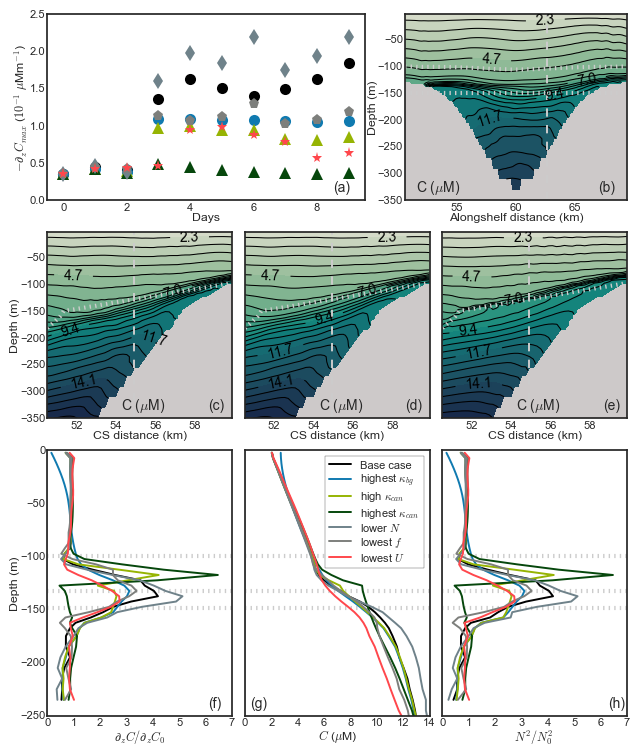

In [14]:
key0 = 'dTrdz_tt00'
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,9.05)) # 190mm = 7.48 in, 230mm = 9,05in

gs = gspec.GridSpec(3, 1, height_ratios=[0.7,0.7,1], hspace=0.15)
gs0 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0],wspace=0.15, width_ratios=[1,0.7])
gs1 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1],wspace=0.07,width_ratios=[1,1,1])
gs2 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2],wspace=0.07,width_ratios=[1,1,1])

ax0 = plt.subplot(gs0[0])
ax1 = plt.subplot(gs0[1])
ax6 = plt.subplot(gs1[0])
ax7 = plt.subplot(gs1[1],yticks=[])
ax8 = plt.subplot(gs1[2],yticks=[])

ax3 = plt.subplot(gs2[0])
ax4 = plt.subplot(gs2[1],yticks=[])
ax5 = plt.subplot(gs2[2],yticks=[])

t=4 # days

#%%%%%%%%%%%%% Contours density Alongshelf %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tslice = slice(6,8)
yslice = 245
xslice = slice(120,240)

Tr_min = 0
Tr_max = 17 

csU2 = np.linspace(Tr_min,Tr_max,num=30)
csU = np.linspace(Tr_min,Tr_max,num=30)
    
mesh=ax1.contourf(grid.X[xslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
ax1.axvline(grid.X[200]/1000,linestyle='--',color='0.8')
ax1.plot(grid.X[xslice]/1000,-grid.Depth[267,xslice],':',color='0.8',linewidth=3)
ax1.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)

CS = ax1.contour(grid.X[xslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )
plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

ax1.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax1.text(0.05,0.05,'C ($\mu$M)',transform=ax1.transAxes,fontsize=10)
ax1.text(0.87,0.05,'(b)',transform=ax1.transAxes,fontsize=10)

ax1.set_ylabel('Depth (m)',labelpad=0.0)
ax1.set_xlabel('Alongshelf distance (km)',labelpad=0)

ax1.tick_params(axis='x', pad=1.5)
ax1.tick_params(axis='y', pad=1.5)

#%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax3.axvline(0,color='0.8',linestyle='-')
ax3.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax3.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax3.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax3.plot(rec.dTrprof[:48]/rec.dTrprof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax3.set_xlabel('$\partial_z C/\partial_z C_0$',labelpad=0.0)
ax3.set_ylim(-250,0)
ax3.set_ylabel('Depth (m)',labelpad=0.0)
ax3.text(0.87,0.03,'(f)',transform=ax3.transAxes,fontsize=10)

ax3.yaxis.set_tick_params(pad=1.5)
ax3.xaxis.set_tick_params(pad=1.5)

#%%%%%%%%%%%%%%%%%%%%% Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4.axvline(0,color='0.8',linestyle='-')
ax4.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax4.plot(rec.Cprof[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax4.set_xlabel('$C$ ($\mu$M)',labelpad=0.0)
ax4.set_ylim(-250,0)
ax4.xaxis.set_tick_params(pad=1.5)
ax4.text(0.03,0.03,'(g)',transform=ax4.transAxes,fontsize=10)
ax4.legend(bbox_to_anchor=(1.0,1.0),ncol=1,labelspacing=0.1,columnspacing=0.1,frameon=True)

#%%%%%%%%%%%%%%%%%%%%% N  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax5.axvline(0,color='0.8',linestyle='-')
ax5.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax5.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax5.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax5.plot(rec.N2prof[:48]/rec.N2prof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax5.set_xlabel('$N^2/N^2_0$ ',labelpad=0.0)
ax5.xaxis.set_tick_params(pad=1.5)
ax5.text(0.9,0.03,'(h)',transform=ax5.transAxes,fontsize=10)

ax5.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% max N evolution %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
keys = ['dTrdz_tt00','dTrdz_tt02','dTrdz_tt04','dTrdz_tt06','dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16','dTrdz_tt18']

for ind in select_rec:
    rec=records[ind]
    tt=0
    for key in keys:
    
        filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                     (rec.name,'DnC'))
        df = pd.read_csv(filename1)

        df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

        plt1, = ax0.plot(tt,-min(df_anom[key][27:])*10,marker=rec.mstyle,markersize=8,color=sns.xkcd_rgb[rec.color2])
        tt=tt+1    
        
#%%%%%%%%%%%%% Contours density cross-shore base %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
yslice = slice(220,270)
xslice = 200
   
mesh=ax6.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
#cbar_ax = f.add_axes([0.9, 0.624, 0.017, 0.276])
#cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,2,4,6,8,10,12,14,16],format='%d')
#cb.ax.yaxis.set_tick_params(pad=1)

ax6.axvline(grid.Y[245]/1000,linestyle='--',color='0.8')
ax6.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,100],':',color='0.8',linewidth=3)

CS = ax6.contour(grid.Y[yslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )
plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

ax6.set_ylabel('Depth (m)',labelpad=0.0)
ax6.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax6.set_xlabel('CS distance (km)',labelpad=0.0)
ax6.text(0.4,0.05,'C ($\mu$M)',transform=ax6.transAxes,fontsize=10)
ax6.text(0.87,0.05,'(c)',transform=ax6.transAxes,fontsize=10)

ax6.tick_params(axis='x', pad=1.5)
ax6.tick_params(axis='y', pad=1.5)

#%%%%%%%%%%%%% Contours density cross-shore kv3 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
yslice = slice(220,270)
xslice = 200
   
mesh=ax7.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracerskv3.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
#cbar_ax = f.add_axes([0.9, 0.624, 0.017, 0.276])
#cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,2,4,6,8,10,12,14,16],format='%d')
#cb.ax.yaxis.set_tick_params(pad=1)

ax7.axvline(grid.Y[245]/1000,linestyle='--',color='0.8')
ax7.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,100],':',color='0.8',linewidth=3)

CS = ax7.contour(grid.Y[yslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(ptracerskv3.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )
plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

ax7.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax7.set_xlabel('CS distance (km)',labelpad=0.0)
ax7.text(0.4,0.05,'C ($\mu$M)',transform=ax7.transAxes,fontsize=10)
ax7.text(0.87,0.05,'(d)',transform=ax7.transAxes,fontsize=10)
ax7.tick_params(axis='x', pad=1.5)

#%%%%%%%%%%%%% Contours density cross-shore kv2 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
yslice = slice(220,270)
xslice = 200
   
mesh=ax8.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracerskv2.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
#cbar_ax = f.add_axes([0.9, 0.624, 0.017, 0.276])
#cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,2,4,6,8,10,12,14,16],format='%d')
#cb.ax.yaxis.set_tick_params(pad=1)

ax8.axvline(grid.Y[245]/1000,linestyle='--',color='0.8')
ax8.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,100],':',color='0.8',linewidth=3)

CS = ax8.contour(grid.Y[yslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(ptracerskv2.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )
plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

ax8.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax8.set_xlabel('CS distance (km)',labelpad=0.0)
ax8.text(0.4,0.05,'C ($\mu$M)',transform=ax8.transAxes,fontsize=10)
ax8.text(0.87,0.05,'(e)',transform=ax8.transAxes,fontsize=10)
ax8.tick_params(axis='x', pad=1.5)

#%%%%%%
ax0.set_xlim(-0.5,9.5)       
ax0.xaxis.set_tick_params(pad=1.5)
ax0.yaxis.set_tick_params(pad=1.5)
    
ax0.set_ylabel('$-\partial_z C_{max}$ ($10^{-1}$ $\mu$Mm$^{-1}$)',labelpad=0.0)
ax0.set_xlabel('Days',labelpad=0)
ax0.text(0.9,0.05,'(a)',transform=ax0.transAxes,fontsize=10)

plt.savefig('figure6.eps',format='eps',bbox_inches='tight')


## Individual plots for talks

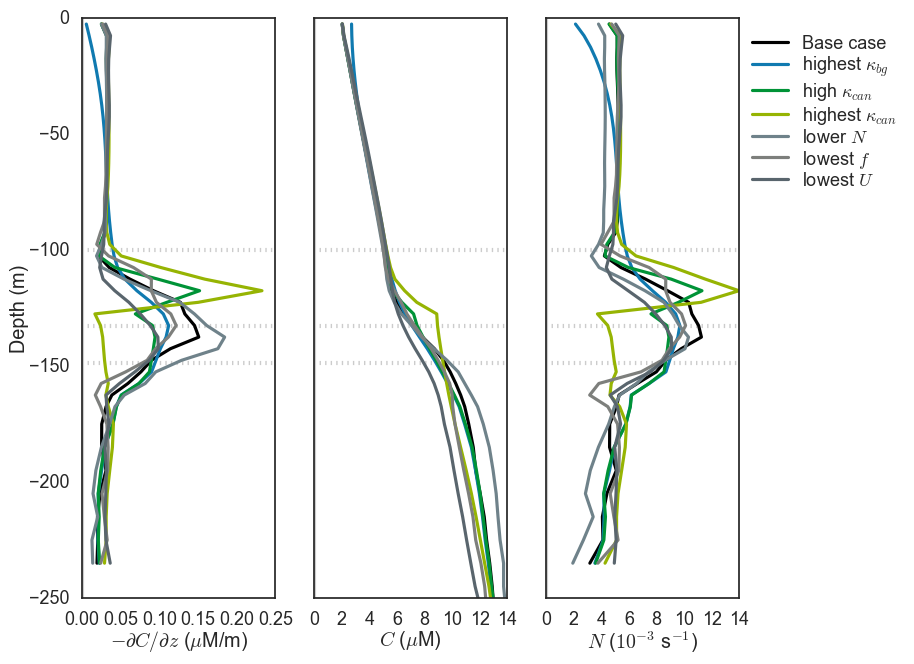

In [20]:
key0 = 'dTrdz_tt00'
sns.set_context('talk')
f = plt.figure(figsize = (8.48,7.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 3, width_ratios=[1,1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0],hspace=0.1)
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,2],hspace=0.1)

ax0 = plt.subplot(gs0[0])

ax2 = plt.subplot(gs1[0],yticks=[])

ax4 = plt.subplot(gs2[0],yticks=[])

t=4 # days

#%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax0.axvline(0,color='0.8',linestyle='-')
ax0.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax0.plot(rec.dTrprof[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax0.set_xlabel('$-\partial C/\partial z$ ($\mu$M/m)',labelpad=0.0)
ax0.set_ylabel('Depth (m)',labelpad=0.0)

ax0.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.axvline(0,color='0.8',linestyle='-')
ax2.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax2.plot(rec.Cprof[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax2.set_xlabel('$C$ ($\mu$M)',labelpad=0.0)

ax2.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% N  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4.axvline(0,color='0.8',linestyle='-')
ax4.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax4.plot(rec.Nprof[:48]/1E-3,grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax4.set_xlabel('$N$ ($10^{-3}$ s$^{-1}$)',labelpad=0.0)
ax4.legend(bbox_to_anchor=(1.9,1.0),ncol=1,labelspacing=0.1,columnspacing=0.1,frameon=False)
ax4.set_ylim(-250,0)

    


plt.savefig('fig_Tr_N_profiles.eps',format='eps',bbox_inches='tight')


(-250, 0)

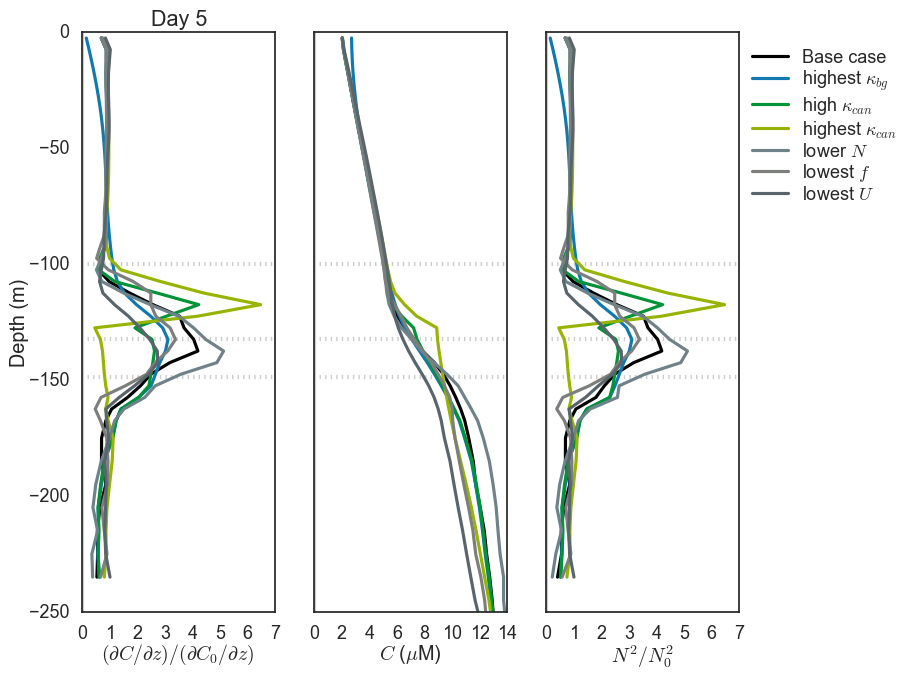

In [30]:
key0 = 'dTrdz_tt00'
sns.set_context('talk')
f = plt.figure(figsize = (8.48,7.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 3, width_ratios=[1,1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0],hspace=0.1)
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,2],hspace=0.1)

ax0 = plt.subplot(gs0[0])

ax2 = plt.subplot(gs1[0],yticks=[])

ax4 = plt.subplot(gs2[0],yticks=[])

t=4 # days

#%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax0.axvline(0,color='0.8',linestyle='-')
ax0.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax0.plot(rec.dTrprof[:48]/rec.dTrprof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax0.set_xlabel('$(\partial C/\partial z) / (\partial C_0/\partial z)$ ',labelpad=0.0)
ax0.set_ylabel('Depth (m)',labelpad=0.0)
ax0.set_title('Day 5')
ax0.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.axvline(0,color='0.8',linestyle='-')
ax2.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax2.plot(rec.Cprof[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax2.set_xlabel('$C$ ($\mu$M)',labelpad=0.0)

ax2.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% N  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4.axvline(0,color='0.8',linestyle='-')
ax4.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax4.plot(rec.N2prof[:48]/rec.N2prof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax4.set_xlabel('$N^2/N^2_0$',labelpad=0.0)
ax4.legend(bbox_to_anchor=(1.9,1.0),ncol=1,labelspacing=0.1,columnspacing=0.1,frameon=False)
ax4.set_ylim(-250,0)

    


#plt.savefig('fig_Tr_N_profiles.eps',format='eps',bbox_inches='tight')


(-250, 0)

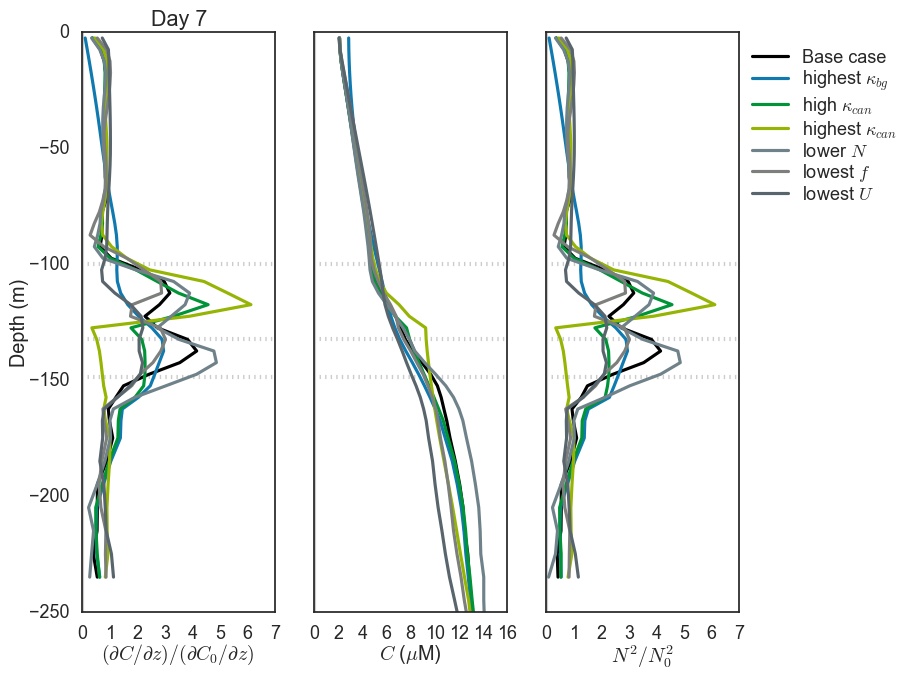

In [31]:
key0 = 'dTrdz_tt00'
sns.set_context('talk')
f = plt.figure(figsize = (8.48,7.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 3, width_ratios=[1,1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,0],hspace=0.1)
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,1],hspace=0.1)
gs2 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0,2],hspace=0.1)

ax0 = plt.subplot(gs0[0])

ax2 = plt.subplot(gs1[0],yticks=[])

ax4 = plt.subplot(gs2[0],yticks=[])

t=4 # days

#%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax0.axvline(0,color='0.8',linestyle='-')
ax0.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax0.plot(rec.dTrprof7[:48]/rec.dTrprof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax0.set_xlabel('$(\partial C/\partial z) / (\partial C_0/\partial z)$ ',labelpad=0.0)
ax0.set_ylabel('Depth (m)',labelpad=0.0)

ax0.set_title('Day 7')
ax0.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.axvline(0,color='0.8',linestyle='-')
ax2.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax2.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax2.plot(rec.Cprof7[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2])
    
ax2.set_xlabel('$C$ ($\mu$M)',labelpad=0.0)

ax2.set_ylim(-250,0)
#%%%%%%%%%%%%%%%%%%%%% N  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax4.axvline(0,color='0.8',linestyle='-')
ax4.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax4.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind,lab in zip(select_rec,labels):
    rec=records[ind]
    ax4.plot(rec.N2prof7[:48]/rec.N2prof0[:48],grid.Z[:48],color=sns.xkcd_rgb[rec.color2],label=lab)
    
ax4.set_xlabel('$N^2/N^2_0$',labelpad=0.0)
ax4.legend(bbox_to_anchor=(1.9,1.0),ncol=1,labelspacing=0.1,columnspacing=0.1,frameon=False)
ax4.set_ylim(-250,0)

    


#plt.savefig('fig_Tr_N_profiles.eps',format='eps',bbox_inches='tight')


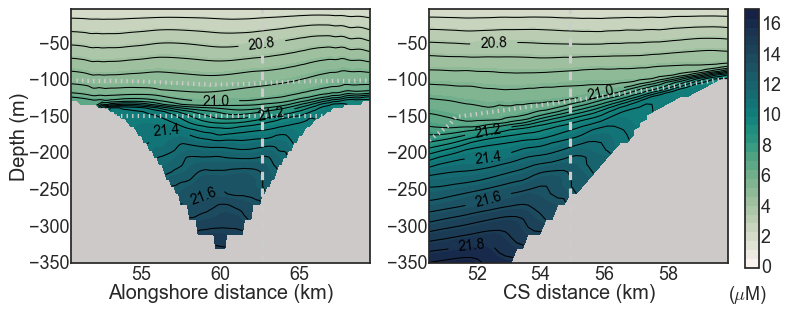

In [94]:
key0 = 'dTrdz_tt00'
plt.rcParams['font.size'] = 13.0
f = plt.figure(figsize = (8.48,11.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 2, width_ratios=[1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0],hspace=0.1,height_ratios=[0.4,1])
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1],hspace=0.1,height_ratios=[0.4,1])

ax0 = plt.subplot(gs0[0])
ax2 = plt.subplot(gs1[0])

t=4 # days

#%%%%%%%%%%%%% Contours density Alongshelf %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tslice = slice(6,8)
yslice = 245
xslice = slice(120,240)

Tr_min = 0
Tr_max = 17 

csU = np.linspace(Tr_min,Tr_max,num=30)
  

rho_min = 1020.4-1000.0
rho_max = 1022.0-1000.0 # 1022.4 if y=230,1021.4 if y=260
density = call_rho(tslice,yslice,xslice)

csU2 = np.linspace(rho_min,rho_max,num=32)

mesh=ax0.contourf(grid.X[xslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
ax0.axvline(grid.X[200]/1000,linestyle='--',color='0.8')
ax0.plot(grid.X[xslice]/1000,-grid.Depth[267,xslice],':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)

CS = ax0.contour(grid.X[xslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )
plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

ax0.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax2.text(1.0,-0.14,'($\mu$M)',transform=ax2.transAxes)
ax0.set_ylabel('Depth (m)',labelpad=0.0)
ax0.set_xlabel('Alongshelf distance (km)',labelpad=0.0)

ax0.tick_params(axis='x', pad=1)
ax0.tick_params(axis='y', pad=1)


#%%%%%%%%%%%%% Contours density cross-shore %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


yslice = slice(220,270)
xslice = 200

rho_min = 1020.4-1000.0
rho_max = 1022.0-1000.0 # 1022.4 if y=230,1021.4 if y=260

density = call_rho(tslice,yslice,xslice)
csU2 = np.linspace(rho_min,rho_max,num=32)

mesh=ax2.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
cbar_ax = f.add_axes([0.92, 0.675, 0.017, 0.225])
cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,2,4,6,8,10,12,14,16],format='%d')
cb.ax.yaxis.set_tick_params(pad=1)

ax2.axvline(grid.Y[245]/1000,linestyle='--',color='0.8')
ax2.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,100],':',color='0.8',linewidth=3)

CS = ax2.contour(grid.Y[yslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )

plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)
ax2.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax2.set_xlabel('CS distance (km)',labelpad=0.0)
ax2.tick_params(axis='x', pad=1)
ax2.tick_params(axis='y', pad=1)


    


plt.savefig('fig_Tr_N_contours.eps',format='eps',bbox_inches='tight')


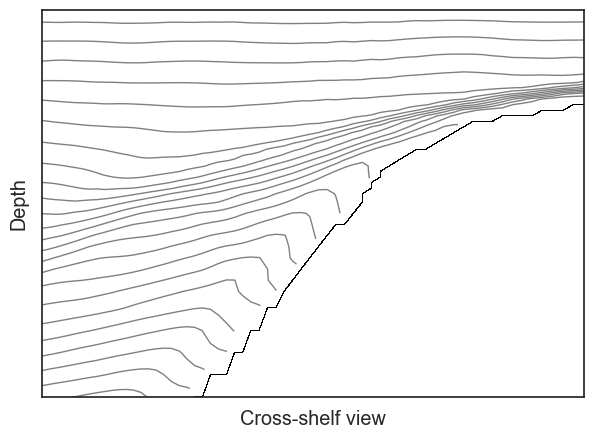

In [121]:

fig,ax = plt.subplots(1,1,figsize=(7,5))

t=4 # days



#%%%%%%%%%%%%% Contours density cross-shore %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
yslice = slice(215,280)
xslice = 200

rho_min = 1020.4-1000.0
rho_max = 1022.0-1000.0 # 1022.4 if y=230,1021.4 if y=260

density = call_rho(tslice,yslice,xslice)
csU2 = np.linspace(rho_min,rho_max,num=32)

CS = ax.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                np.nanmean(density[:,:48,:].data-1000,axis=0),
                [0,0.2],colors='k',linewidths=[2]) 

CS = ax.contour(grid.Y[yslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                csU2,colors='gray',linewidths=[1] )

ax.set_axis_bgcolor((255/255.0, 255/255.0, 255/255.0))
ax.set_xlabel('Cross-shelf view',labelpad=0.0)
ax.set_ylabel('Depth',labelpad=0.0)

ax.set_xticklabels([])
ax.set_yticklabels([])


    


plt.savefig('isopycnals_CS_scheme.eps',format='eps',bbox_inches='tight')


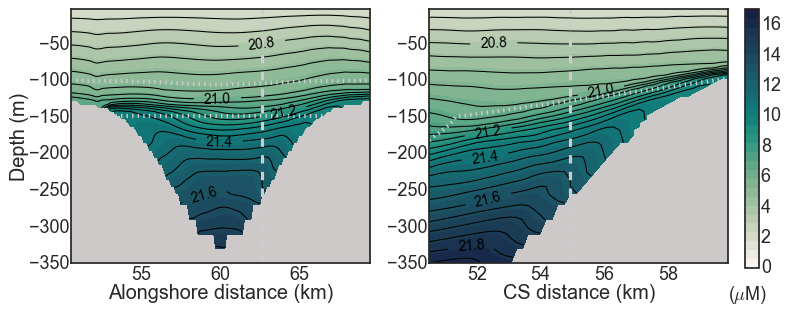

In [98]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)


key0 = 'dTrdz_tt00'
plt.rcParams['font.size'] = 13.0
f = plt.figure(figsize = (8.48,11.48)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 2, width_ratios=[1,1],wspace=0.2)
gs0 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0],hspace=0.1,height_ratios=[0.4,1])
gs1 = gspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[1],hspace=0.1,height_ratios=[0.4,1])

ax0 = plt.subplot(gs0[0])
ax2 = plt.subplot(gs1[0])

t=4 # days

#%%%%%%%%%%%%% Contours density Alongshelf %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tslice = slice(6,8)
yslice = 245
xslice = slice(120,240)

Tr_min = 0
Tr_max = 17 

csU = np.linspace(Tr_min,Tr_max,num=30)
  

rho_min = 1020.4-1000.0
rho_max = 1022.0-1000.0 # 1022.4 if y=230,1021.4 if y=260
density = call_rho(tslice,yslice,xslice)

csU2 = np.linspace(rho_min,rho_max,num=32)

mesh=ax0.contourf(grid.X[xslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
ax0.axvline(grid.X[200]/1000,linestyle='--',color='0.8')
ax0.plot(grid.X[xslice]/1000,-grid.Depth[267,xslice],':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)

CS = ax0.contour(grid.X[xslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )
plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)

ax0.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax2.text(1.0,-0.14,'($\mu$M)',transform=ax2.transAxes)
ax0.set_ylabel('Depth (m)',labelpad=0.0)
ax0.set_xlabel('Alongshelf distance (km)',labelpad=0.0)

ax0.tick_params(axis='x', pad=1)
ax0.tick_params(axis='y', pad=1)


#%%%%%%%%%%%%% Contours density cross-shore %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


yslice = slice(220,270)
xslice = 200

rho_min = 1020.4-1000.0
rho_max = 1022.0-1000.0 # 1022.4 if y=230,1021.4 if y=260

density = call_rho(tslice,yslice,xslice)
csU2 = np.linspace(rho_min,rho_max,num=32)

mesh=ax2.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(ptracers.Tr1[tslice,:48,yslice,xslice].data,axis=0),
                             mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.tempo)
    
cbar_ax = f.add_axes([0.92, 0.675, 0.017, 0.225])
cb=f.colorbar(mesh, cax=cbar_ax,ticks=[0,2,4,6,8,10,12,14,16],format='%d')
cb.ax.yaxis.set_tick_params(pad=1)

ax2.axvline(grid.Y[245]/1000,linestyle='--',color='0.8')
ax2.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,100],':',color='0.8',linewidth=3)

CS = ax2.contour(grid.Y[yslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )

plt.clabel(CS,csU2[::4],inline=True, fmt='%.1f',fontsize=10)
ax2.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax2.set_xlabel('CS distance (km)',labelpad=0.0)
ax2.tick_params(axis='x', pad=1)
ax2.tick_params(axis='y', pad=1)


    


plt.savefig('fig_Tr_N_contours_HighKvCanE3.eps',format='eps',bbox_inches='tight')
